In [1]:
import pandas as pd
import numpy as np
import spacy
import scispacy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Dropout, Embedding, Dense, Flatten, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2024-03-03 20:33:13.760794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 20:33:13.760888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 20:33:13.762347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 20:33:13.771520: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 20:33:14.598404: W tensorflow/compiler/tf2

In [2]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz

In [3]:
# Load the SciSpaCy model
nlp = spacy.load("en_core_sci_sm")

/home/paperenv/lib/python3.10/site-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [4]:
# Read CSV file
df = pd.read_csv('data.csv')
df = df.dropna(subset=['text', 'label']) # Remove all rows with missing values
df['text'] = df['text'].str.replace(r'[^\w\s]+', '', regex=True) # Remove all punctuation
df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii') # Remove all non-ASCII chars
df['label'] = df['label'].str.lower()

In [5]:
# Preprocess text and extract features
def preprocess_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

df['text'] = df['text'].apply(preprocess_text)

In [6]:
df['text']

0       need add water drug vaccine ready administer p...
1       Hydroxychloroquine show effective rate treat D...
2       Fact Hydroxychloroquine show effective rate tr...
3       Corona virus man virus create Wuhan laboratory...
4       not billgates finance research Wuhan lab Coron...
                              ...                        
1159    study suggest ultraviolet ray slow virus wipe ...
1160    week medical journal report business traveler ...
1161    new report send White House science adviser sa...
1162    vaccine ultimate weapon coronavirus good route...
1163    develop deliver coronavirus vaccine test treat...
Name: text, Length: 1151, dtype: object

In [7]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [8]:
# Split data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.25, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)  

In [9]:
# Tokenize text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
# X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = max(len(seq) for seq in X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
# X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)


In [10]:
# Define the model architecture
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len),
    LSTM(units=25),
    Dropout(0.5),
    BatchNormalization(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
27/27 [==============================] - 21s 715ms/step - loss: 0.6631 - accuracy: 0.5968 - val_loss: 0.6919 - val_accuracy: 0.4514
Epoch 2/50
27/27 [==============================] - 19s 688ms/step - loss: 0.4667 - accuracy: 0.8343 - val_loss: 0.6577 - val_accuracy: 0.6597
Epoch 3/50
27/27 [==============================] - 18s 682ms/step - loss: 0.2259 - accuracy: 0.9513 - val_loss: 0.5511 - val_accuracy: 0.8090
Epoch 4/50
27/27 [==============================] - 18s 680ms/step - loss: 0.1064 - accuracy: 0.9919 - val_loss: 0.4494 - val_accuracy: 0.8924
Epoch 5/50
27/27 [==============================] - 19s 690ms/step - loss: 0.0547 - accuracy: 0.9965 - val_loss: 0.4087 - val_accuracy: 0.8576
Epoch 6/50
27/27 [==============================] - 18s 681ms/step - loss: 0.0386 - accuracy: 0.9965 - val_loss: 0.3519 - val_accuracy: 0.8785
Epoch 7/50
27/27 [==============================] - 18s 681ms/step - loss: 0.0288 - accuracy: 0.9977 - val_loss: 0.3357 - val_accuracy: 0.8611

In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

9/9 [==============================] - 1s 110ms/step - loss: 0.8655 - accuracy: 0.8681
Loss: 0.8655471205711365
Accuracy: 0.8680555820465088


In [12]:
# Predict labels
y_pred_probs = model.predict(X_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

9/9 [==============================] - 1s 115ms/step
Accuracy: 0.8680555555555556
Precision: 0.8765432098765432
Recall: 0.8875
F1 Score: 0.8819875776397516


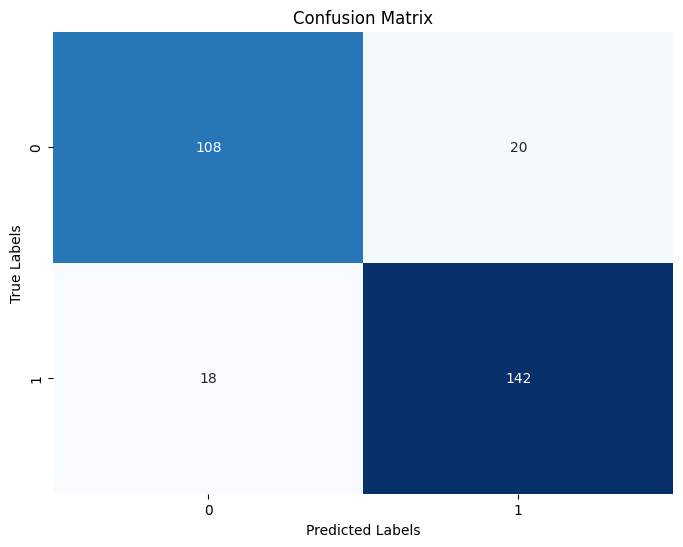

In [13]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()